# Notes

DHC key metrics

- thermal load density
- load factor (average / peak load)
- diversity factor (central equipment design load / sum of peak load)

## *ASHRAE HVAC Application CHAPTER 34 GEOTHERMAL ENERGY*

The following classification by temperature is used in the geothermal industry:

- High temperature t > 150°C
- Intermediate temperature 90°C < t < 150°C
- Low temperature t < 90°C

> Electric generation is generally not economical for resources
with temperatures below about 150°C, which is the reason for the
division between high- and intermediate-temperature. However,
binary (organic Rankine cycle) power plants, with the proper set of
circumstances, have demonstrated that it is possible to generate
electricity economically above 110°C. In 1988, there were 86
binary plants worldwide, generating a total of 126.3 MW (Di Pippo
1988).

Hybrid systems are a variation of ground-coupled systems in
which a smaller ground loop is used, augmented in cooling mode by
a fluid cooler or a cooling tower. This approach can have merit in
large cooling-dominated applications. The ground loop is sized to
meet the heating requirements. The downsized loop is used in con-
junction with the fluid cooler or cooling tower with an isolation heat
exchanger to meet the heat rejection load. Using the cooler reduces
the capital cost of the ground loop in such applications, but some-
what increases maintenance requirements. For heavily heating-
dominant applications, a downsized loop also can be augmented with
an auxiliary heat source such as electric resistance, solar collectors,
or fossil fuel.

## *Analysis of the impact of storage conditions on the thermal recovery efficiency of low-temperature ATES systems*

> The energy demand profile of ATES systems varies due to variations
in weather conditions and building use which is of importance for the
actual value of the thermal efficiency. For 12 varying scenarios the
efficiencies are determined for both a weather dependent and the reg-
ular energy demand profile, showing that the efficiencies of the corre-
sponding conditions differ. However, they show the same relation ac-
cording to the changes in conditions; the Pearson correlation coefficient
of the two simulation result collections is 0,97. Based on this evaluation
all simulations are done with one basic energy demand profile

In [55]:
from collections import OrderedDict

from datetime import datetime

from ladybug.epw import EPW  #  pip install ladybug-core


def flatten(l):
    """[[x, y], z] -> [x, y, z]"""
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, str):
            for sub in flatten(el):
                yield sub
        else:
            yield el
            

def read_epw(path, year=None, tlabels=dict(y='Year', m='Month', d='Day', h='Hour', M='Minute')):
    epw_list = EPW(path).to_dict()['data_collections']
    epw_dict = dict()

    for dat in epw_list:
        data_name = dat['header']['data_type']['name']
        epw_dict[data_name] = dat['values']

    df = pd.DataFrame(epw_dict)

    def get_ts(row):
        # Keep time in LST
        year = int(row[tlabels['y']])
        if row[tlabels['h']] != 24:  # conversion h=24 into h=0
            t = pd.Timestamp(datetime(int(row[tlabels['y']]), int(row[tlabels['m']]), int(row[tlabels['d']]), int(row[tlabels['h']])))
        else:
            t = pd.Timestamp(datetime(int(row[tlabels['y']]), int(row[tlabels['m']]), int(row[tlabels['d']]), 23))
            t += pd.Timedelta(1, 'h')
            t = t.replace(year=year)
        return t

    # POSIX has positive signs west of Greenwich, but many people expect
    # positive signs east of Greenwich.  For example, TZ='Etc/GMT+4' uses
    # the abbreviation "GMT+4" and corresponds to 4 hours behind UTC
    # (i.e. west of Greenwich) even though many people would expect it to
    # mean 4 hours ahead of UTC (i.e. east of Greenwich).

    if year is not None:
        df[tlabels['y']] = year
    
    df['ts'] = df.apply(get_ts, axis=1)  # TMY2 en LST + cf. convention POSIX
    
    return df

# Constants & conversion factors

In [42]:
# Select node for analysis
node = 'Biosciences'

In [43]:
# Constants
# Careful: Absorption chiller efficiency is homogeneous to a COP (heat flow rate/power) whereas electric chiller efficiency is in kW/ton so 1/EER!!!
file_path = './loads/2019-05-31 Building energy and loads.xlsx'
sheet_name = 'Inputs'
df = pd.read_excel(file_path, sheet_name, skiprows=11, nrows=11)
df = df[[x for x in df.columns if 'Unnamed' not in x]]
df.rename(lambda x: re.sub(' ', '', x), axis='columns', inplace=True)
cst = df.copy()
cst = pd.concat([
    cst,
    pd.DataFrame(dict(
        Parameter=['J/Btu', 'kW/ton', 'kW/(kBtu/h)', 'J/kWh', 'm2/sqft'],
        Value=[1055.06, 3.51685, 1000 / 3600 * 1055.06 / 1000, 3.6e+6, 0.092903]))
])
cst.set_index('Parameter', inplace=True)
cst

/home/agautier/miniconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning:

Conditional Formatting extension is not supported and will be removed



Value       Unit  \
Parameter                                                       
Existing building-level steam loss    1.500000e-01          %   
Enthalpy                              9.700000e+02     Btu/lb   
Btu/kBtu                              1.000000e+03   Btu/kBtu   
Gas efficiency                        8.000000e-01          %   
Btu per W                             3.412000e+00      Btu/W   
Btu per therm                         1.000000e+05  Btu/therm   
Absorption chiller efficiency         4.000000e-01        COP   
Existing electric chiller efficiency  1.250000e+00     kW/ton   
New electric chiller efficiency       5.000000e-01     kW/ton   
Building heating system efficiency    9.500000e-01          %   
Btuh per ton                          1.200000e+04   Btuh/ton   
J/Btu                                 1.055060e+03        NaN   
kW/ton                                3.516850e+00        NaN   
kW/(kBtu/h)                           2.930722e-01        NaN   
J/kWh                                 3.600000e+06        NaN   
m2/sqft                               9.290300e-02        NaN   

                                                                                 Source  
Parameter                                                                                
Existing building-level steam loss    Assumption to convert from steam usage to heat...  
Enthalpy                                                                            NaN  
Btu/kBtu                                                                       Constant  
Gas efficiency                                                               Assumption  
Btu per W                                                                      Constant  
Btu per therm                                                                  Constant  
Absorption chiller efficiency         Assumption based on average chiller age and di...  
Existing electric chiller efficiency  Assumption based on average chiller age and di...  
New electric chiller efficiency       Assumption based on average chiller age and di...  
Building heating system efficiency    Assumption to convert from steam usage to heat...  
Btuh per ton                                                                   Constant  
J/Btu                                                                               NaN  
kW/ton                                                                              NaN  
kW/(kBtu/h)                                                                         NaN  
J/kWh                                                                               NaN  
m2/sqft                                                                             NaN

# Loads and energy use

## Peak loads

In [44]:
file_path = './loads/2019-05-31 Building energy and loads.xlsx'
sheet_name = 'Peak Load Calc'
df = pd.read_excel(file_path, sheet_name, skiprows=12)
missing_names = ['CAAN','Building Name','Building Type','Year Constructed',	'Year Demolished',	
                 'Building Area (sqft)', 'Node', 'Cluster']
df.columns.values[1:9] = missing_names
df.columns.values[9] = 'Cooling Type'
df.columns.values[11] = 'Peak Steam Intensity (Btuh/sqft)'
df = df[[x for x in df.columns if 'Unnamed' not in x]]
df.rename(lambda x: re.sub(' ', '', x), axis='columns', inplace=True)
df = df[~df.BuildingType.isna()]
loa = df.copy()
# SI conversion (kW)
loa['PeakHeating'] = loa['PeakHeating'] * cst.at['kW/(kBtu/h)', 'Value']
loa['PeakCooling'] = loa['TotalChillerCapacity'] * cst.at['kW/ton', 'Value']
loa.tail()

/home/agautier/miniconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning:

Conditional Formatting extension is not supported and will be removed

/home/agautier/miniconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning:

Data Validation extension is not supported and will be removed



CAAN              BuildingName BuildingType  YearConstructed  \
114  1800  Lawrence Hall of Science    Classroom           1968.0   
115  1286               Tang Center        Admin           1993.0   
116  1033                 Chou Hall    Classroom           2018.0   
117  1787              Upper Hearst    Residence           2021.0   
118  1520        Bakar Bioenginuity   Bioscience           1970.0   

     YearDemolished  BuildingArea(sqft) Node Cluster       CoolingType  \
114             NaN            128540.0  NaN     NaN  Packaged VAV, DX   
115             NaN             75228.0  NaN     NaN  Packaged VAV, DX   
116             NaN             80000.0  NaN     NaN  Packaged VAV, DX   
117             NaN             54000.0  NaN     NaN  Packaged VAV, DX   
118             NaN            102794.0  NaN     NaN  Packaged VAV, DX   

     PeakSteamIntensity(Btuh/sqft)  ...  Process.3  SpaceHeating.1  DHW.4  \
114                          10.10  ...        NaN             NaN    NaN   
115                          10.10  ...        NaN             NaN    NaN   
116                          10.10  ...        NaN             NaN    NaN   
117                          14.14  ...        NaN             NaN    NaN   
118                          41.44  ...        NaN             NaN    NaN   

     Absorption.4  Process.4  SpaceHeating.2  DHW.5  Absorption.5  Process.5  \
114           NaN        NaN             NaN    NaN           NaN        NaN   
115           NaN        NaN             NaN    NaN           NaN        NaN   
116           NaN        NaN             NaN    NaN           NaN        NaN   
117           NaN        NaN             NaN    NaN           NaN        NaN   
118           NaN        NaN             NaN    NaN           NaN        NaN   

    PeakCooling  
114  452.055899  
115  264.565592  
116  281.348000  
117  132.936930  
118  903.777697  

[5 rows x 45 columns]

## Heating and cooling energy

Based on electricity and steam EU.

> Need to update cooling energy as currently design chiller COP is used to convert from electricity.

In [111]:
file_path = './loads/2019-05-31 Building energy and loads.xlsx'
sheet_name = 'Annual Energy Calc'
df = pd.read_excel(file_path, sheet_name, skiprows=12)
missing_names = ['CAAN','Building Name','Building Type','Year Constructed',	'Year Demolished',	
                 'Building Area (sqft)', 'Node', 'Cluster']
df.columns.values[1:9] = missing_names
df.columns.values[10] = 'Electricity Use (kWh/y)'
df.columns.values[16] = 'Steam Use (kBtu/y)'
df = df[[x for x in df.columns if 'Unnamed' not in x]]
df.rename(lambda x: re.sub(' ', '', x), axis='columns', inplace=True)
df = df[~df.BuildingType.isna()]
eus = df.copy()

eus.tail()

/home/agautier/miniconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning:

Conditional Formatting extension is not supported and will be removed



CAAN                                BuildingName BuildingType  \
96   1292 (N)                              Lewis Hall (N)    Chemistry   
97      CAAN?                         Lewis Hall Addition    Chemistry   
98       1785                                Oxford Tract    Residence   
99       1601                                Peoples Park    Residence   
100  1774 (N)  Tolman Hall (N) (Climate Science Building)   Bioscience   

     YearConstructed  YearDemolished  BuildingArea(sqft)  \
96            2040.0             NaN             87500.0   
97            2028.0             NaN             90000.0   
98            2025.0             NaN           1050000.0   
99            2023.0             NaN            432000.0   
100           2025.0             NaN            292500.0   

                                   Node            Cluster  \
96   Engineering, Physics and Chemistry  Engineering Lewis   
97   Engineering, Physics and Chemistry  Engineering Lewis   
98                          Biosciences       Oxford Tract   
99                 Lower Sproul offices       Peoples Park   
100                         Biosciences  Biosciences North   

     ElectricityUse(kWh/y)  Cooling&HeatRejection  ...  Absorption.1  \
96               4179700.0                   0.25  ...           NaN   
97               4299120.0                   0.25  ...           NaN   
98              11106060.0                   0.00  ...           NaN   
99               4569350.4                   0.00  ...           NaN   
100             13972140.0                   0.25  ...           NaN   

     Process.1  Cooling&HeatRejection.2 Vent&Fans.2  \
96         NaN                      NaN         NaN   
97         NaN                      NaN         NaN   
98         NaN                      NaN         NaN   
99         NaN                      NaN         NaN   
100        NaN                      NaN         NaN   

     InteriorandExteriorLighting.2  PlugsandMisc..2  SpaceHeating.2  DHW.2  \
96                             NaN              NaN             NaN    NaN   
97                             NaN              NaN             NaN    NaN   
98                             NaN              NaN             NaN    NaN   
99                             NaN              NaN             NaN    NaN   
100                            NaN              NaN             NaN    NaN   

     Absorption.2 Process.2  
96            NaN       NaN  
97            NaN       NaN  
98            NaN       NaN  
99            NaN       NaN  
100           NaN       NaN  

[5 rows x 36 columns]

In [113]:
load_diversity = dict(
    heating_node=0.85,
    heating_campus=0.80,
    cooling_node=0.95,
    cooling_campus=0.90,
)

In [114]:
# Peak loads - Campus
loa['PeakHeating'].sum() * load_diversity['heating_campus'], loa['PeakCooling'].sum() * load_diversity['cooling_campus']  # kw

(67303.10263876154, 89011.676633256)

In [115]:
# Capacity weighted chiller efficiency COP (-)
# This is without heat recovery that requires higher condenser temperature so lower COP!
## Whole campus
COP_campus = 1 / (
        (loa['Efficiency(kW/ton)'] * loa['TotalChillerCapacity']).sum() /\
        loa['TotalChillerCapacity'].sum() / cst.at['kW/ton', 'Value'])
## Node
COP_node = 1 / (
(loa.set_index('Node').loc[node, 'Efficiency(kW/ton)'] *\
 loa.set_index('Node').loc[node, 'TotalChillerCapacity']).sum() /\
    loa.set_index('Node').loc[node, 'TotalChillerCapacity'].sum() / cst.at['kW/ton', 'Value'])
## Heat recovery COP from `Global Inputs` in `2020-04-20 UCB utilities calculation_accelerated phasing`
COP_HR = 1 / (1 / cst.at['kW/ton', 'Value'])
print(COP_campus, COP_node, COP_HR)

4.3497463340703 4.762747927832286 3.51685


## Hourly load profile

In [116]:
from scipy.optimize import minimize_scalar

In [117]:
peak_cooling = loa.set_index('Node').loc[node, 'PeakCooling'].sum() * load_diversity['cooling_node']  # kW
peak_heating = loa.set_index('Node').loc[node, 'PeakHeating'].sum() * load_diversity['heating_node']  # kW
peak_cooling /1000, peak_heating / 1000

(15.540209935557998, 11.340473789644012)

From `2020-09-23 UCB load data to DOE`

> These hourly heating and cooling profiles were derived for the 2019 UC Berkeley Campus Energy Plan to estimate heat recovery potential and thermal storage tank size. These profiles were created using Arup's in-house District Energy Feasibility (DEF) tool. The DEF tool takes in location, building area by use type (office, residential, etc.), and building age, estimates load for each building type using PNNL’s commercial building reference models, and scales to match the input on a sqft basis. ***The resulting campus profiles were scaled linearly so that the peaks matched actual peak loads (derived from measured steam and electricity usage and installed chiller capacity).***

This scaling method applied to the node yields annual cooling (heating) energy 3 (2) times lower than the one from `Annual Energy Calc`.

In [118]:
file_path = './loads/2020-09-23 UCB load data to DOE.xlsx'
sheet_name = 'Hourly load profiles'
df = pd.read_excel(file_path, sheet_name, skiprows=11)
df.rename(lambda x: re.sub(' ', '', x), axis='columns', inplace=True)
df.Date = pd.to_datetime(df.Date).dt.round('H')
df.set_index('Date', inplace=True)
# SI conversion: kBtu/h to kW
df.loc[:, ['Cooling', 'Heating']] *= cst.loc['kW/(kBtu/h)'].Value
# df = df[['Date', 'Cooling', 'Heating']].melt(id_vars='Date')
lot = df[['Cooling', 'Heating']].copy()
# Add month and hour of day and max heat flow rate from condenser heat recovery
lot['month'] = lot.index.month
lot['hour'] = lot.index.hour

lot['Cooling_raw'] = lot.Cooling.copy()
lot['Heating_raw'] = lot.Heating.copy()

In [119]:
# Scale for peak load     
scp_cooling = peak_cooling / lot.Cooling.max()
scp_heating = peak_heating / lot.Heating.max()
lot.Cooling = lot.Cooling * scp_cooling
lot.Heating = lot.Heating * scp_heating

# Compute seasonal chiller COP
df = read_epw('./energyplus/USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw', year=2018)
df['wbt'] = np.vectorize(GetTWetBulbFromRelHum, excluded='Pressure')(df['Dry Bulb Temperature'], df['Relative Humidity'] / 100)


def cop_wbt(df, cop_nom=4.5, cwst_min=15, approach=5, dcop_dcwst=-0.3/10):
    """df Dataframe with Cooling and wbt columns"""
    df['cwst_min'] = cwst_min
    df['cwst'] = df.wbt + approach
    df['cwst'] = df[['cwst_min', 'cwst']].max(axis=1)
    df['dcwst'] = df['cwst'] - df['cwst'].max()
    df['cop'] = cop_nom * (1 + dcop_dcwst * df['dcwst'])
    cop = df.Cooling.sum() / (df.Cooling / df.cop).sum()
    
    return cop
    
COP_seasonal = cop_wbt(pd.concat([df.set_index('ts')['wbt'], lot.Cooling], axis=1), cop_nom=COP_node)
COP_node, COP_seasonal    

(4.762747927832286, 5.6518394991629215)

In [120]:
# Compute distributed energy in kWh/y
eus['COP'] = 1 / (eus.apply(lambda x: loa.set_index('BuildingName').at[x.BuildingName, 'Efficiency(kW/ton)'], axis=1) / cst.at['kW/ton', 'Value'])
eus['COP_seasonal'] = eus['COP'] * COP_seasonal / COP_node
## Assumptions: Cooling = Cooling&HeatRejection
eus['CoolingElec'] = eus['ElectricityUse(kWh/y)'] * eus['Cooling&HeatRejection'] * eus['COP_seasonal']
eus['SteamEnergy'] = eus['SteamUse(kBtu/y)'] * (1 - cst.at['Existing building-level steam loss', 'Value']) * 1000 *\
                     cst.loc['J/Btu'].Value / cst.at['J/kWh', 'Value']
eus['SpaceHeating'] = eus['SteamEnergy'] * eus['SpaceHeating']
eus['DHW'] = eus['SteamEnergy'] * eus['DHW']
eus['Process'] = eus['SteamEnergy'] * eus['Process']
# Careful: Absorption chiller efficiency is homogeneous to a COP (heat output/heat input) 
eus['CoolingAbsorption'] = eus['SteamEnergy'] * eus['Absorption'] * cst.at['Absorption chiller efficiency', 'Value']
eus['Cooling'] = eus['CoolingElec'] + eus['CoolingAbsorption'] 

In [121]:
# Load factors - Node
LF_cooling = eus.set_index('Node').loc[node, 'Cooling'].sum() / 8760 / loa.set_index('Node').loc[node, 'PeakCooling'].sum()
LF_heating = (eus.set_index('Node').loc[node, 'SpaceHeating'] + eus.set_index('Node').loc[node, 'DHW']).sum() / 8760 /\
             loa.set_index('Node').loc[node, 'PeakHeating'].sum()
LF_cooling, LF_heating

(0.46181792400598076, 0.6038473822478909)

In [122]:
# Scale for integral load under the constraint of unchanged range
# Including DHW in heating, excluding process = same assumption as 'Peak Heating' in 'Peak Load Calc'
eus_cooling = eus.set_index('Node').loc[node, 'Cooling'].sum()
eus_heating = (eus.set_index('Node').loc[node, 'SpaceHeating'] + eus.set_index('Node').loc[node, 'DHW']).sum()


def scale(q, k, qmin, qmax, qmean):
    if q < qmean:
        y = (k * qmean  - qmin) / (qmean - qmin) * (q - qmin) + qmin
        return max(qmin, y)
    else:
        y = (k * qmean  - qmax) / (qmean - qmax) * (q - qmax) + qmax
        return min(qmax, y) 

    
for typ in ['Cooling', 'Heating']:
    if typ == 'Heating':
        eus_actual = eus_heating
    else:
        eus_actual = eus_cooling
        
    def obj(k):
        tmp = lot[typ].resample("60min").mean()
        return (tmp.apply(scale, args=(k, tmp.min(), tmp.max(), tmp.mean())).sum() - eus_actual)**2
    
    res = minimize_scalar(obj, bounds=[0, 10], method='bounded')
    print(typ, res.x, res.success)
    lot[typ] = lot[typ].apply(scale, args=(res.x, lot[typ].min(), lot[typ].max(), lot[typ].mean()))

    
# Add month and hour of day and max heat flow rate from condenser heat recovery
# (In heat recovery, the chiller lift is constant.)
lot['MaxHeatRecovery'] = lot.Cooling * (1 + 1 / COP_HR)
lot['MaxHeatRecovery'] = lot[['MaxHeatRecovery', 'Heating']].min(axis=1)

lot.tail()

Cooling 8.821075420306745 True
Heating 2.5959512085223007 True


Cooling       Heating  month  hour  Cooling_raw  \
Date                                                                       
2018-12-31 19:00:00  3675.048995  10152.645157     12    19  5233.865122   
2018-12-31 20:00:00  3264.256933  10152.896414     12    20  4871.184406   
2018-12-31 21:00:00  2285.157380  10128.794760     12    21  4006.755515   
2018-12-31 22:00:00  1795.733733  10168.793663     12    22  3574.652425   
2018-12-31 23:00:00  1955.781787  10015.515740     12    23  3715.955893   

                      Heating_raw  MaxHeatRecovery  
Date                                                
2018-12-31 19:00:00  32172.215122      4720.032146  
2018-12-31 20:00:00  32179.363227      4192.433265  
2018-12-31 21:00:00  31493.688348      2934.931292  
2018-12-31 22:00:00  32631.628616      2306.342298  
2018-12-31 23:00:00  28270.980942      2511.899274

In [123]:
# Check peak load and EU
peak_cooling / lot.loc[lot.Cooling==lot.Cooling.max(), 'Cooling'].values[0], eus_cooling / lot.Cooling.resample("60min").mean().sum() 

(0.967821721864018, 0.9999999999999772)

In [124]:
# Check peak load and EU
peak_heating / lot.loc[lot.Heating==lot.Heating.max(), 'Heating'].values[0], eus_heating / lot.Heating.resample("60min").mean().sum() 

(1.0, 0.9999999999999998)

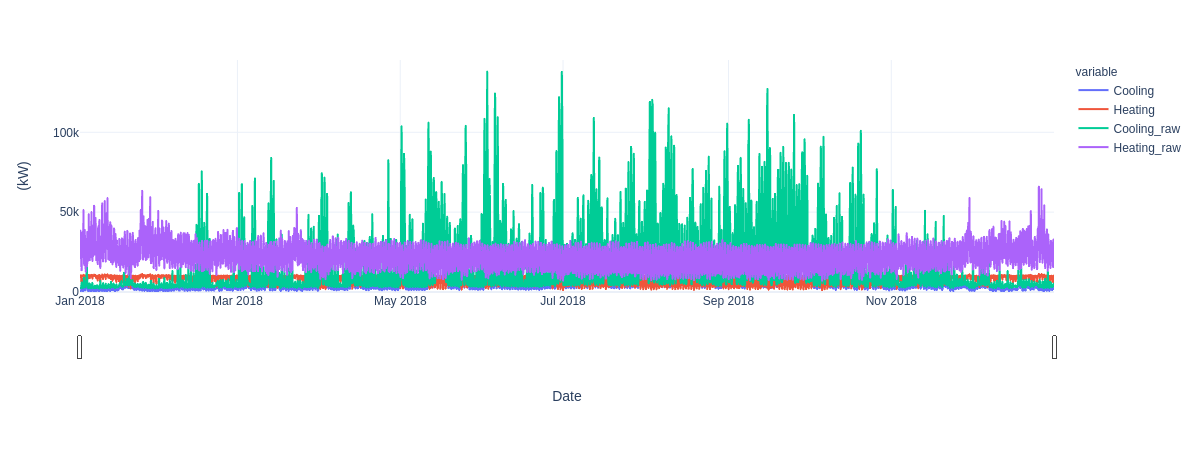

In [125]:
toplot = lot[['Cooling', 'Heating', 'Cooling_raw', 'Heating_raw']].melt(ignore_index=False)
# toplot = lot[['Cooling', 'Heating', 'MaxHeatRecovery']].melt(ignore_index=False)
fig = px.line(toplot, x=toplot.index, y='value', color='variable')
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
    ),
    yaxis=dict(rangemode='tozero', title='(kW)')
)
# fig.data.append(go.Scattergl(x=df['Date/Time'], y=df['Hourly Space Cooling load (W)']/1000))
fig

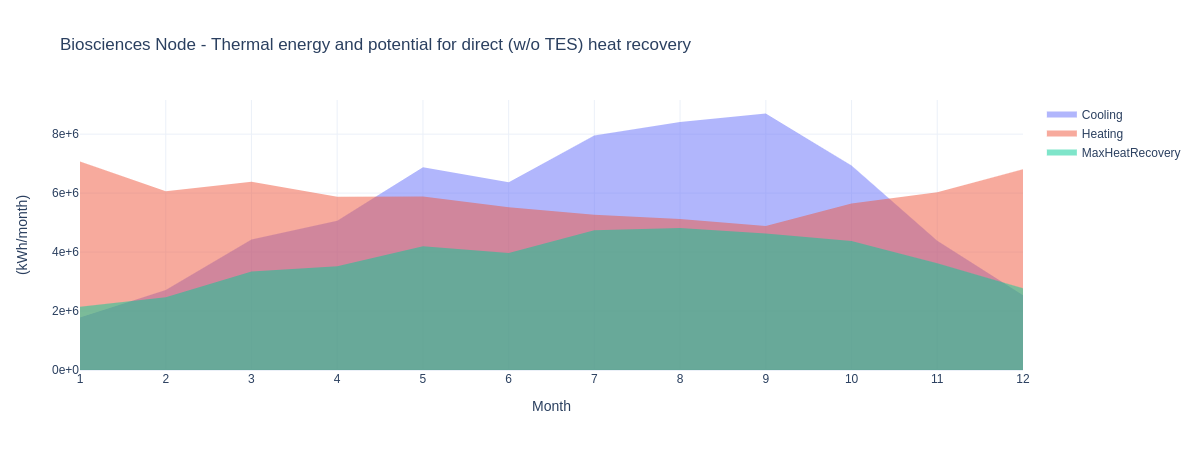

In [126]:
toplot = lot[['Cooling', 'Heating', 'MaxHeatRecovery']].resample("60min").mean()
toplot['month'] = toplot.index.month
toplot = toplot.groupby('month').sum()

fig = go.Figure()
fig.add_trace(go.Scatter(x=toplot.index, y=toplot.Cooling, fill='tozeroy', name='Cooling', mode='none'))
fig.add_trace(go.Scatter(x=toplot.index, y=toplot.Heating, fill='tozeroy', name='Heating', mode='none'))
fig.add_trace(go.Scatter(x=toplot.index, y=toplot.MaxHeatRecovery, fill='tozeroy', name='MaxHeatRecovery', mode='none'))

fig.update_layout(title=f'{node} Node - Thermal energy and potential for direct (w/o TES) heat recovery')
fig.update_yaxes(title='(kWh/month)', tickformat="e")
fig.update_xaxes(title='Month', dtick=1)
fig

In [16]:
fig.write_image("fig.svg")

In [127]:
figs = []
for m in pd.unique(lot.month):
    toplot = lot.loc[lot.month==m]
    toplot = toplot.groupby('hour').mean()
    toplot = toplot[['Cooling', 'Heating', 'MaxHeatRecovery']].melt(ignore_index=False)
    fig = px.line(toplot, x=toplot.index + 1, y='value', color='variable', title=dt.date(2000, m, 1).strftime('%B'))
    fig.update_xaxes(title='Hour of the day', dtick=1)
    fig.update_yaxes(title='(kW)', rangemode='tozero')
    figs.append(fig)

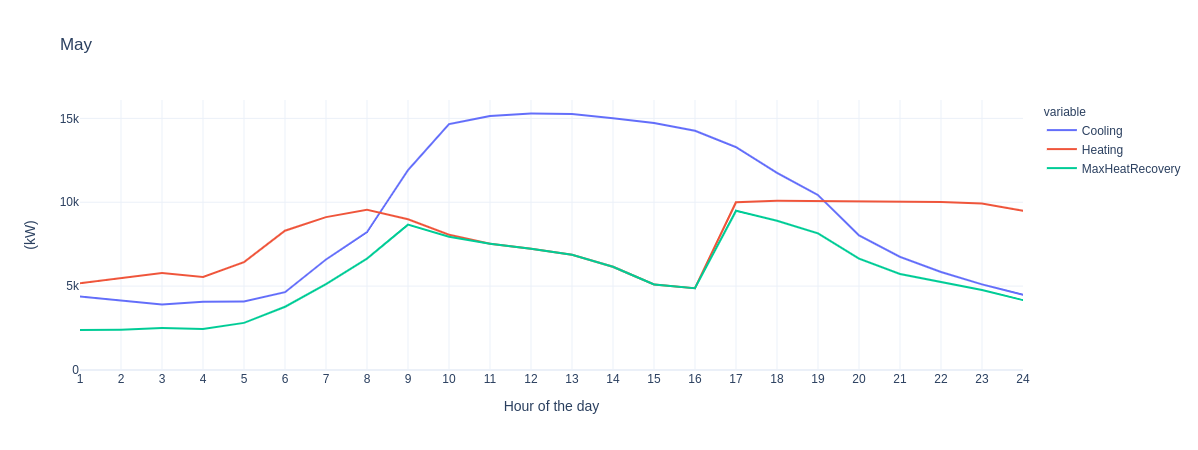

In [128]:
figs[4]

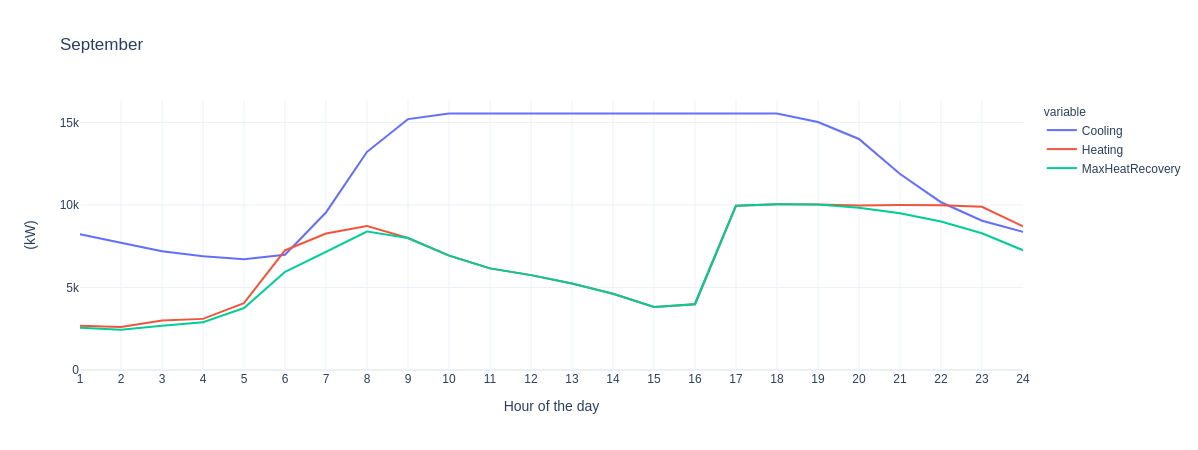

In [129]:
figs[8]

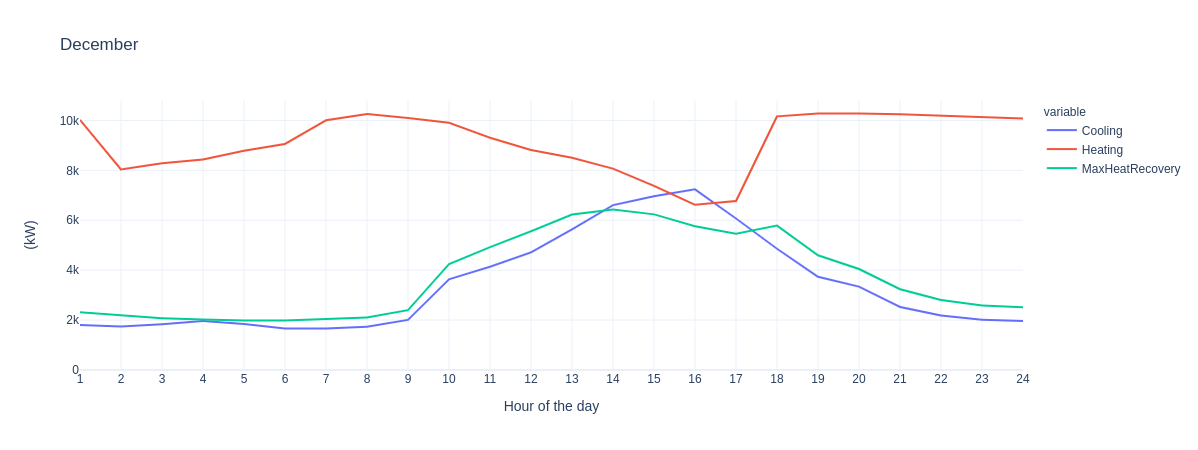

In [130]:
figs[11]

# GCHP Design 

> Equations (2) and (3) consider three different pulses of heat to
account for long-term heat imbalances q a , average monthly heat
rates during the design month, and maximum heat rates for a short-
term period during a design day. This period could be as short as 1 h,
but a 4 to 6 h block is recommended.

In [142]:
lot.max()

Cooling             16056.893108
Heating             11340.473790
month                  12.000000
hour                   23.000000
Cooling_raw        138007.774164
Heating_raw         65965.093160
MaxHeatRecovery     10236.967613
CondRej             18976.328219
EvapAbs              8100.338421
dtype: float64

In [131]:
# Design months
PLFm = lot.resample('1M').mean() 
Ql_4 = lot.resample('240min').mean()
PLFm.Heating = PLFm.Heating / Ql_4.Heating.max()
PLFm.Cooling = PLFm.Cooling / Ql_4.Cooling.max()
max_PLFm = dict(
    Cooling=PLFm.loc[PLFm.Cooling==PLFm.Cooling.max(), 'Cooling'].values[0],
    Heating=PLFm.loc[PLFm.Heating==PLFm.Heating.max(), 'Heating'].values[0],
)
max_PLFm, PLFm

({'Cooling': 0.767326349995347, 'Heating': 0.8814291251099262},
              Cooling   Heating  month  hour   Cooling_raw   Heating_raw  \
 Date                                                                      
 2018-01-31  0.152162  0.881429    1.0  11.5   4144.824993  28914.799019   
 2018-02-28  0.256513  0.836491    2.0  11.5   7395.813579  24993.795709   
 2018-03-31  0.378027  0.795087    3.0  11.5  10864.568337  23085.660816   
 2018-04-30  0.446616  0.756081    4.0  11.5  12374.287911  21439.529401   
 2018-05-31  0.587276  0.733250    5.0  11.5  21398.141408  20634.643818   
 2018-06-30  0.562009  0.710506    6.0  11.5  23230.097293  20024.855104   
 2018-07-31  0.679132  0.656365    7.0  11.5  21871.268823  18891.270081   
 2018-08-31  0.717802  0.638667    8.0  11.5  28104.334761  18502.424635   
 2018-09-30  0.767326  0.628629    9.0  11.5  31059.697669  18203.791332   
 2018-10-31  0.592367  0.704184   10.0  11.5  18977.605117  19988.143797   
 2018-11-30  0.386464  0

In [132]:
tmp = loa.loc[loa.BuildingName.str.contains('Tolman'), ['PeakHeating', 'TotalChillerCapacity']]
peak_tolman_heating = tmp.PeakHeating.values[0] * cst.at['kW/(kBtu/h)', 'Value']
peak_tolman_cooling = tmp.TotalChillerCapacity.values[0] * cst.at['kW/ton', 'Value']
peak_tolman_heating, peak_tolman_cooling

(840.693061201908, 2571.6965625)

In [133]:
peak_heating, peak_cooling

(11340.473789644011, 15540.209935557998)

In [134]:
peak_tolman_cooling / peak_cooling

0.16548660366650694

In [135]:
eus.loc[loa.BuildingName.str.contains('Tolman'), ['SpaceHeating', 'DHW', 'Cooling']].applymap("{:.1e}".format)

SpaceHeating      DHW  Cooling
100      3.4e+06  1.5e+06  2.5e+07

In [136]:
eus.set_index('Node').loc[node, ['SpaceHeating', 'DHW', 'Cooling']].sum().map("{:.1e}".format)  # kWh/y

SpaceHeating    5.0e+07
DHW             2.1e+07
Cooling         6.6e+07
dtype: object

In [27]:
# Building area: total gross floor area?
# ETHZ campus Hönggerberg = 360e3 m2 Energy reference area
# EU area = Sum of all above and below ground floor areas for the use of which heating or air conditioning is necessary
# with a total gross floor area of approximately 47,000 m2 (SIA 416) by 2018; experts estimate the associated energy reference area (EBF) to be around 15% smaller
eus.loc[eus.Node==node, 'BuildingArea(sqft)'].sum() * cst.at['m2/sqft', 'Value']

228533.390342

$$ 
Lc = \frac{q_a R_{ga} + (q_{lc}-W_c)(R_b + PLF_m R_{gm} + R_{gd} F{sc})}
{t_g - \frac{t_{wi} + t_{wo}}{2} - t_p}
$$
$$ 
Lh = \frac{q_a R_{ga} + (q_{lh}-W_h)(R_b + PLF_m R_{gm} + R_{gd} F{sc})}
{t_g - \frac{t_{wi} + t_{wo}}{2} - t_p}
$$

NOTA
> $\dot{Q}$ should be negative when transferring heat *to* the ground ($\bar{t}_w > t_g$).
Cf. simple steady-state formulation $\dot{Q} = \frac{L(t_g - \bar{t}_w)}{R}$.
Hence $W_c$ gets combined to $\dot{Q}$.
Same convention holds when computing $q_a$.


*Zhang 2016*
> The total annual heat input to the ground during the cooling mode is entered
as a negative value and must include the heat of compression. The total heat removed during
the heating mode is a positive value

*ASHRAE 2011*
> qa: net annual average heat transfer to ground, kW

In [143]:
# QCond_cool = QEvap + P = QEvap * (1 + 1 / COP_cool)
# QEvap_heat = QCond - P = QCond * (1 - 1 / COP_heat)
COP_cool = 5.5
COP_heat = 3.5  # Updated from 4.1 as the plant produces HW ~ 60C for DHW production (data from Carrier 30XWH-/30XWHP 254-1762).
# Or we use DH only for DHW preheating but existing building heating systems probably require a minimum 60 C.
lot['CondRej'] = lot['Cooling'] * (1 + 1 / COP_cool)
lot['EvapAbs'] = lot['Heating'] * (1 - 1 / COP_heat)
qa = -lot['CondRej'].mean() + lot['EvapAbs'].mean()
print(qa, lot['Cooling'].mean(), lot['Heating'].mean(), 'kW')
# Equivalent hours at full load
EFLHc = lot['Cooling'].sum() / lot['Cooling'].max()
EFLHh = lot['Heating'].sum() / lot['Heating'].max()
EFLHc, EFLHh, qa

-3173.460467072162 7554.471043217552 8056.371072149831 kW


(4121.417879133166, 6223.180080578265, -3173.460467072162)

In [144]:
lot['CondRej'].mean()

8928.01123289347

In [145]:
# Ground temperature t_g = 65 F
tg = (65 - 32) * 5/9  # C  source for tg value: tg = 13.6 from mean annual DBT
# Ground conductivity k_g = 1.4 Btu/(hr*ft*F)
kg = 1.4 * 1.73 # W/(m.K)
# Ground thermal diffusivity a_g = 1 ft^2/day
ag = 1 * 0.3048**2  # m2/d
# Bore fill conductivity k_b = 1 Btu/(hr*ft*F)
kb = 1 * 1.73 # W/(m.K)
# Static water table at 50 ft below surface = 15.24 m
# 25 mm DR11 HDPE pipe, 150 mm borehole, Rb from ASHRAE 2011 Table 6
db = 150e-3
Rb = 0.17
tg, kg, kb, ag

(18.333333333333332, 2.4219999999999997, 1.73, 0.09290304)

In [146]:
# G factor
t1 = 3650; t2 = 3680; tf = 3680.25  # d
Fof = 4 * ag * tf / db**2
Fo1 = 4 * ag * (tf - t1) / db**2
Fo2 = 4 * ag * (tf - t2) / db**2
Fof, Fo1, Fo2

(60783.362304, 499.61190400000004, 4.129024)

In [147]:
Gf = 0.94; G1 = 0.55; G2 = 0.24
Rga = (Gf - G1) / kg; Rgm = (G1 - G2) / kg; Rgd = G2 / kg
Rga, Rgm, Rgd

(0.16102394715111476, 0.1279933938893477, 0.0990916597853014)

> Selecting twi to be 11
to 17 K higher than tg in cooling and 6 to 11 K lower than tg in heating
is a good compromise between first cost and efficiency in many
regions of the United States.

# Check tp values and sign that differ between ASHRAE 2011 and Yi Zhang 2016

In [153]:
twi_cool = 30
twi_heat = 10
dt = 5

Fsc = 1.04
tp = 0.1  # Out of chart, cooling dominated (qa < 0), high sensitivity to that variable!
Cf = 1.14  # For 20x20 grid
tp = Cf * tp

In [154]:
qlc = -Ql_4.Cooling.max()
Wc = -qlc / COP_node
PLF_m = max_PLFm['Cooling']
twi = twi_cool
two = twi - dt
Lc = (qa * 1e3 * Rga + (qlc - Wc) * 1e3 * (Rb + PLF_m * Rgm + Rgd * Fsc)) / (tg - (twi + two) / 2 + tp)
Lc / 200, qlc, Wc  # Number of boreholes of 200 m depth

(4189.896484338615, -15749.378988221868, 3306.784072318106)

In [155]:
qlh = Ql_4.Heating.max()
Wh = qlh / COP_HP
PLF_m = max_PLFm['Heating']
twi = twi_heat
two = twi + dt
Lh = (qa * 1e3 * Rga + (qlh - Wh) * 1e3 * (Rb + PLF_m * Rgm + Rgd * Fsc)) / (tg - (twi + two) / 2 + tp)
Lh / 200, qlh, Wh  # Number of boreholes of 200 m depth

(2070.339547028605, 10788.654166779095, 3082.4726190797414)

In [156]:
# CHECK
# ETHZ targets 800 boreholes of 200 m to cover 23 GWh heat/year and 22 GWh cold/year
800 * eus_heating / 23e6, 800 * eus_cooling / 22e6

(2454.741237983739, 2406.4424123121544)